In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from pprint import pprint

import lerobot
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from lerobot.common.datasets.factory import make_dataset


from hydra import compose, initialize
from omegaconf import OmegaConf

# context initialization
with initialize(version_base=None, config_path="../configs", job_name="test_app"):
    cfg = compose(config_name="default")
    print(OmegaConf.to_yaml(cfg))

resume: false
device: cuda
use_amp: false
seed: 100000
dataset_repo_id: lerobot/pusht
video_backend: pyav
training:
  offline_steps: 200000
  num_workers: 4
  batch_size: 64
  eval_freq: 10000
  log_freq: 200
  save_checkpoint: true
  save_freq: 100000
  online_steps: 0
  online_rollout_n_episodes: 1
  online_rollout_batch_size: 1
  online_steps_between_rollouts: 1
  online_sampling_ratio: 0.5
  online_env_seed: null
  online_buffer_capacity: null
  online_buffer_seed_size: 0
  do_online_rollout_async: false
  image_transforms:
    enable: false
    max_num_transforms: 3
    random_order: false
    brightness:
      weight: 1
      min_max:
      - 0.8
      - 1.2
    contrast:
      weight: 1
      min_max:
      - 0.8
      - 1.2
    saturation:
      weight: 1
      min_max:
      - 0.5
      - 1.5
    hue:
      weight: 1
      min_max:
      - -0.05
      - 0.05
    sharpness:
      weight: 1
      min_max:
      - 0.8
      - 1.2
  grad_clip_norm: 10
  lr: 0.0001
  lr_scheduler: 

In [3]:
# get the path to the dataset
import pandas as pd
import numpy as np
from pathlib import Path
env_name = 'genesis' # 'ros' # 'pusht' # 'pinpad' # 'robosuite'
imi = 0
notes = 'diff_eef'

# base_path = Path(f"~/workspace/lerobot/local/{env_name}/original").expanduser()
# base_path = Path(f"~/workspace/fastrl/logs/HD_pinpad_four_1/a").expanduser()
AI = False
tdmpc = False
USE_BOTTOM_IMAGE = False

def get_files(env_name, imi, AI=False, tdmpc=False, resize=False):
    if tdmpc:
        bp = f"~/workspace/fastrl/logs/demonstrations/TDMPC_pusht_HD_{imi}_sparse/"
        od = f"~/workspace/lerobot/local/{env_name}/tdmpc{imi}"
        assert not AI
    else:    
        if AI:
            bp = f"~/workspace/fastrl/logs/AD_pusht_{imi}/"
            od = f"~/workspace/lerobot/local/{env_name}/A{imi}"
        else:
            bp = f"~/workspace/fastrl/logs/HD_{env_name}_{imi}/"
            od = f"~/workspace/lerobot/local/{env_name}/{imi}"

    if resize:
        od = od + "_96x96"

    base_path = Path(bp).expanduser()
    out_dir = Path(od).expanduser()

    print(base_path, end=" ")
    # list all the files in the dataset
    folders = list(base_path.glob("*")); print(f"Found {len(folders)} folders")

    files = []
    for f in folders:
        files.extend((base_path / f).glob("*"))
    return files, out_dir

files, out_dir = get_files(env_name, imi, AI=AI, tdmpc=tdmpc)

print(files)

# print the keys
data = np.load(files[0])
# convert to a dictionary NOTE: this is necessary to make the arrays writeable for some reason
data = dict(data)
for k,v in data.items():
    print(k, v.shape)

# print("Setting last is_terminal to true")
# data["is_terminal"][-1] = True; data['is_last'][-1] = True

/home/j/workspace/fastrl/logs/HD_genesis_0 Found 1 folders
[PosixPath('/home/j/workspace/fastrl/logs/HD_genesis_0/eef/20250424T011215-2e7b3e9b1a8347a5be30d75f7d093c27-1201.npz'), PosixPath('/home/j/workspace/fastrl/logs/HD_genesis_0/eef/20250424T004324-4ff6bda3a2314be3a67614445bfef436-181.npz'), PosixPath('/home/j/workspace/fastrl/logs/HD_genesis_0/eef/20250424T010023-e028a4e069c74100bfc15386532a9f33-189.npz'), PosixPath('/home/j/workspace/fastrl/logs/HD_genesis_0/eef/20250424T005710-eb9efaf785e7472f8d869e5d1f65e998-400.npz'), PosixPath('/home/j/workspace/fastrl/logs/HD_genesis_0/eef/20250424T005831-67bb11da90314b9b8d54f6879d8f0522-438.npz'), PosixPath('/home/j/workspace/fastrl/logs/HD_genesis_0/eef/20250424T005220-259d872f7c70470a9f9c74c3dd2030d2-879.npz'), PosixPath('/home/j/workspace/fastrl/logs/HD_genesis_0/eef/20250424T005108-1289b60999a745e4a1d49ac8573fd1a3-351.npz'), PosixPath('/home/j/workspace/fastrl/logs/HD_genesis_0/eef/20250424T004946-833702554bf8498db3de6956b3baf310-364.np

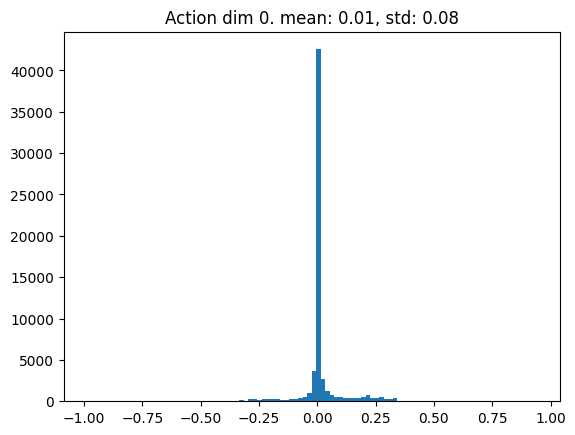

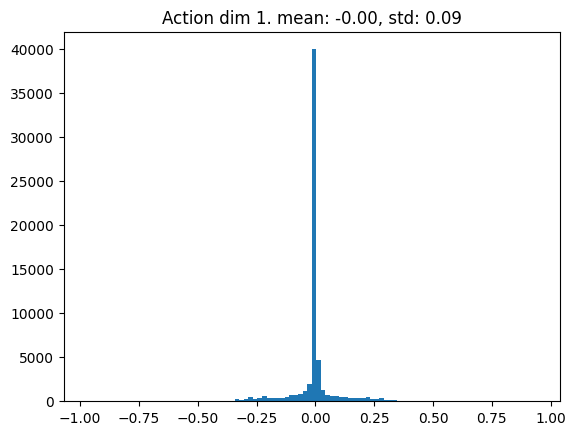

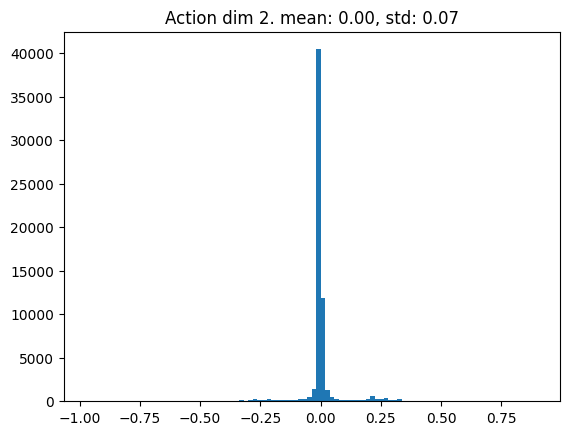

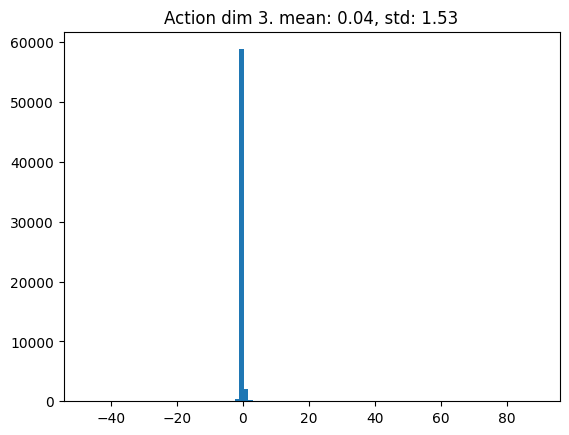

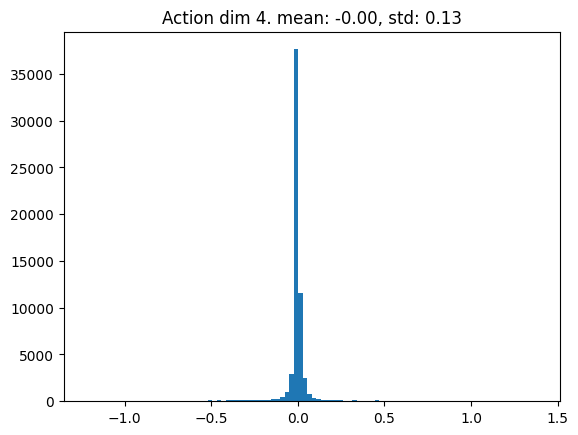

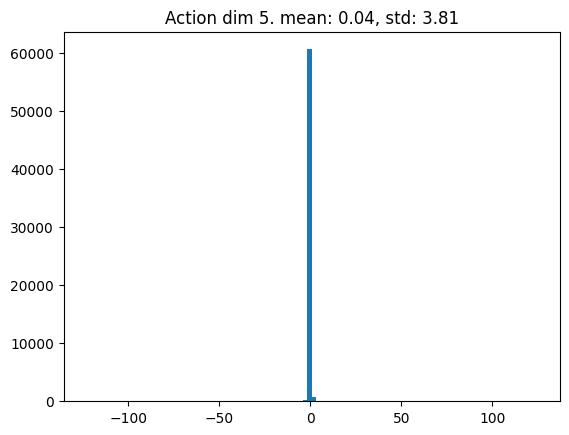

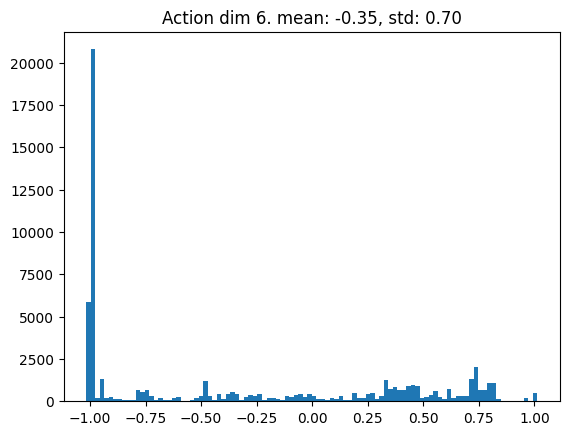

<Figure size 640x480 with 0 Axes>

In [4]:

successful_runs_lengths = []
all_actions = []
all_states = []
for f in files:
    # read, convert to a dictionary NOTE: this is necessary to make the arrays writeable for some reason
    data = np.load(f); data = dict(data)

    # print(len(data['image_top']), np.sum([entry for entry in data['reward'] if entry > 0]), data['reward'][-1])

    all_zero_actions = 0
    if data['reward'][-1] > 0:
        successful_runs_lengths.append(len(data['reward']) - 1)
        # for a in data['action']:
        #     if np.all(a == 0):
        #         all_zero_actions += 1
    all_actions.extend(data['action'])
    all_states.extend(data['state'])

    image_key = 'image'
    # print(data[image_key].min(), data[image_key].max(), f'all zero actions: {all_zero_actions} / {len(data["action"])}')
    # print(data[image_key].min(), data[image_key].max())
import matplotlib.pyplot as plt
# plt.hist(successful_runs_lengths, bins=100, range=(0, 700))

# make a hist of action dim 2 (z)
plt.figure()

all_actions = np.array(all_actions)
for i in range(all_actions.shape[1]):
    a = all_actions[:,i]
    plt.hist(a, bins=100) # , range=(-0.5, 0.5))
    plt.title(f"Action dim {i}. mean: {np.mean(a):.2f}, std: {np.std(a):.2f}")
    plt.figure()

CUTOFF = ''

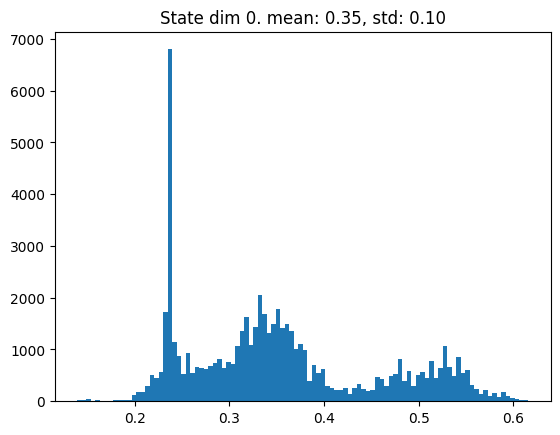

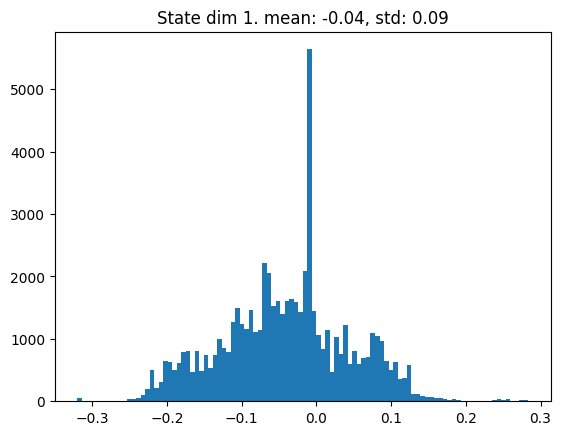

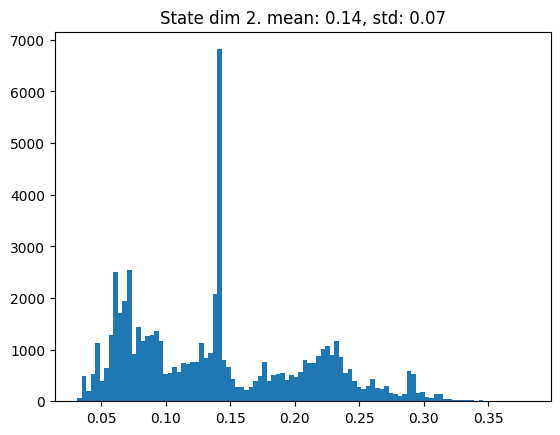

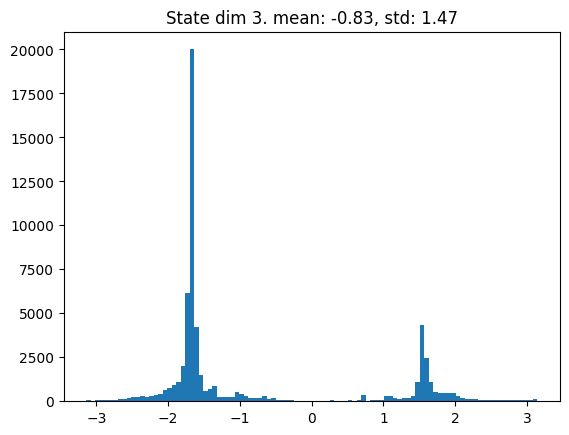

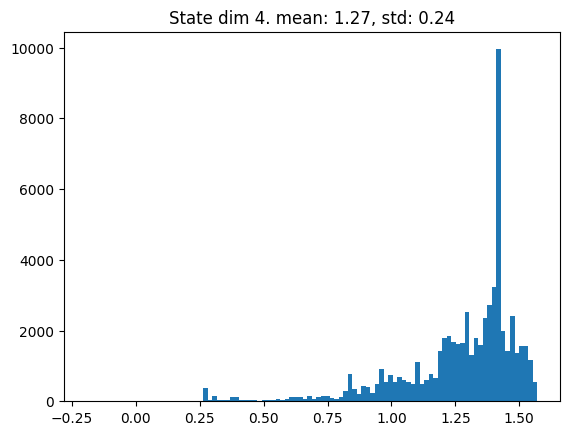

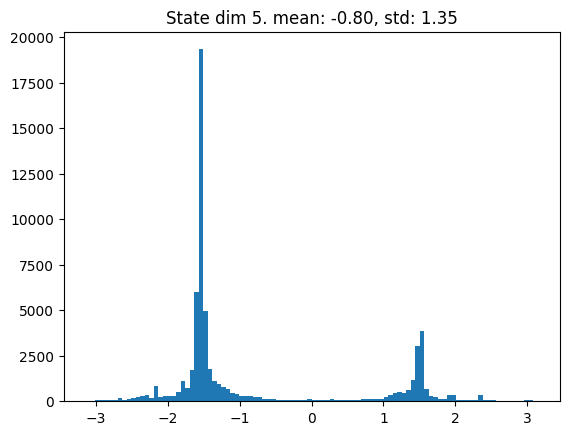

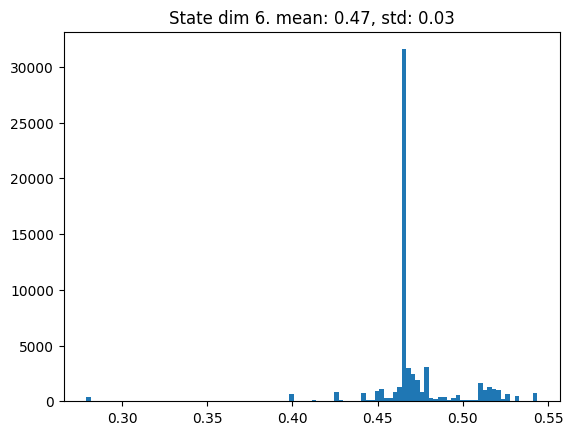

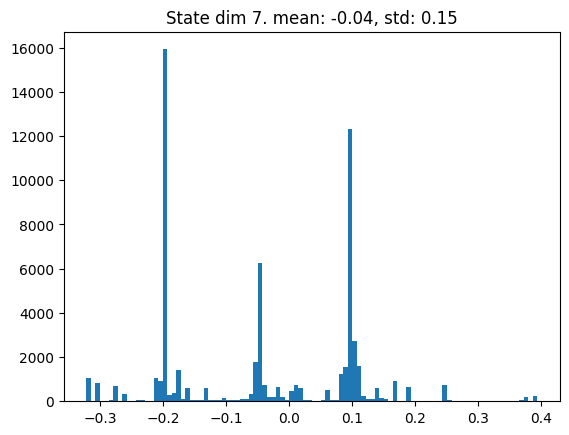

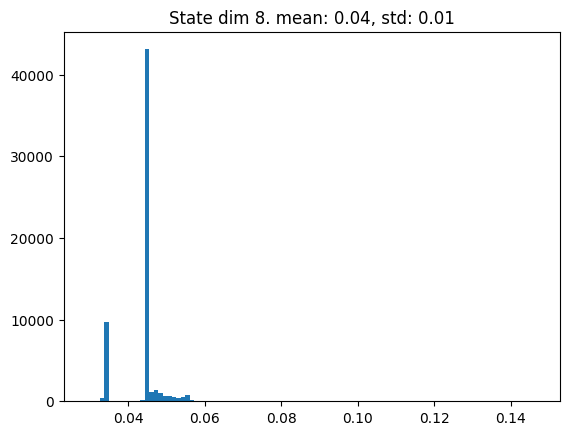

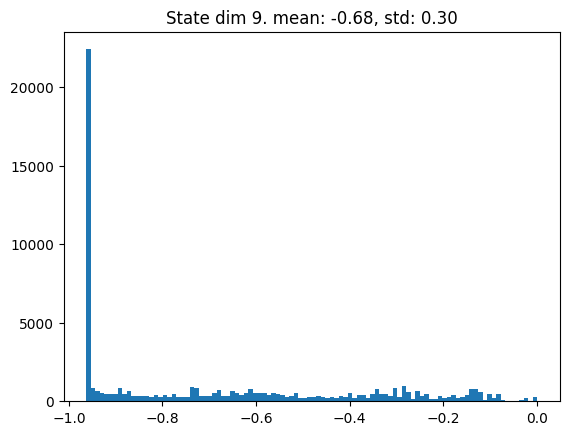

<Figure size 640x480 with 0 Axes>

In [5]:
all_states = np.array(all_states)
for i in range(all_states.shape[1]):
    s = all_states[:,i]
    plt.hist(s, bins=100) # , range=(-0.5, 0.5))
    plt.title(f"State dim {i}. mean: {np.mean(s):.2f}, std: {np.std(s):.2f}")
    plt.figure()

In [21]:
np.mean(all_actions, axis=0), np.std(all_actions, axis=0), np.min(all_actions, axis=0), np.max(all_actions, axis=0)

(array([-2.5857678e-02, -1.2731451e+00,  1.7681937e+00, -1.7805027e+00,
         1.4989440e+00, -1.6593399e+00,  3.3393711e+01], dtype=float32),
 array([ 0.3506821 ,  0.2089235 ,  0.46051335,  0.58737665,  0.4641626 ,
         0.28215215, 35.255775  ], dtype=float32),
 array([-0.936561  , -1.7833656 , -0.82304513, -2.6126828 , -0.6779411 ,
        -2.6079335 , -0.99752796], dtype=float32),
 array([  0.9016941,   0.6395607,   2.6197245,   0.8640008,   2.253419 ,
          0.9054762, 100.683586 ], dtype=float32))

In [6]:
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
import shutil
repo_id = f"j/{imi}"
root = Path(f'~/workspace/lerobot/local/{env_name}_{imi}_{notes}{CUTOFF}{"_BOT" if USE_BOTTOM_IMAGE else ""}').expanduser()
dst = Path(f'~/.cache/huggingface/hub/datasets--{env_name}_{imi}_{notes}{CUTOFF}{"" if not USE_BOTTOM_IMAGE else "_BOT"}').expanduser()

if dst.exists():
    shutil.rmtree(dst)
if root.exists():
    shutil.rmtree(root)
    
# root.mkdir(exist_ok=True)
# shutil.rmtree(root, ignore_errors=True)



# loaded_dataset = LeRobotDataset(repo_id, dst, local_files_only=True)
# loaded_dataset.num_episodes, loaded_dataset.num_frames
# loaded_dataset.meta.stats


In [7]:


use_videos = True

# h, w, ch = data['image_top'][0].shape
img_shape = data['image'][0].shape
ch = 3
h, w = img_shape[:2]

state_ndims = data['state'][0].shape[0]
action_ndims = data['action'][0].shape[0]

print(h, w, ch, state_ndims, action_ndims)

features = {
    "observation.image.top": {
        "dtype": "video" if use_videos else "image",
        "shape": [h, w, ch],
        "names": ['height', 'width', 'channels'],
        "info": None},
    "observation.state": {
        "dtype": "float32",
        "shape": (state_ndims,),
        "names": [f's{i}' for i in range(state_ndims)],
    },
    "action": {
        "dtype": "float32",
        "shape": (action_ndims,),
        "names": [f'a{i}' for i in range(action_ndims)],
    },
    "next.reward": {
        "dtype": "float32",
        "shape": (1,),
        "names": None,
    },
    "next.success": {
        "dtype": "bool",
        "shape": (1,),
        "names": None,
    },
}

if USE_BOTTOM_IMAGE:
    features["observation.image.bottom"] = {
        "dtype": "video" if use_videos else "image",
        "shape": [h, w, ch],
        "names": ['height', 'width', 'channels'],
        "info": None}

# metadata = LeRobotDatasetMetadata(repo_id, root, local_files_only=True)
dataset = LeRobotDataset.create(
    repo_id,
    fps=30, # from pusht.yaml
    root=root,
    use_videos=use_videos,
    features=features
)

96 96 3 10 7


In [8]:
from lerobot.common.datasets.utils import DEFAULT_FEATURES

mapping = {
    'image': 'observation.image.top',
    'state': 'observation.state',
    'action': 'action',
    'reward': 'next.reward',
}

if USE_BOTTOM_IMAGE:
    mapping['image_bottom'] = 'observation.image.bottom'


zero_action_frames_skipped = 0
for f in files:
    # read, convert to a dictionary NOTE: this is necessary to make the arrays writeable for some reason
    data = np.load(f); data = dict(data)

    if CUTOFF != '' and len(data['image']) > CUTOFF:
        print(f"Skipping {f} due to length {len(data['image'])}")
        continue

    nsteps = len(data['image'])
    for t in range(nsteps):
        frame = {}
        for local_key, lerobot_key in mapping.items():
            if "image" in lerobot_key:
                # expand the grayscale image to 3 channels
                img = data[local_key][t]
                
                # if the max of the images is above 1, normalize it
                img = img.astype(np.float32)
                if img.max() > 1:
                    img = img / 255.0 # normalize to [0, 1]
                
                if len(img.shape) == 2:
                    img = np.stack([img]*3, axis=-1)


                frame[lerobot_key] = img
            else:
                frame[lerobot_key] = data[local_key][t]
            # if local_key == 'action': 
                # frame[lerobot_key] = (frame[lerobot_key] + 1.) * 256 # NOTE: specifically for gym-pusht


        frame['next.success'] = data['reward'][t] > 0

        # Skip frames with all zero actions
        if np.all(frame['action'] == 0):
            zero_action_frames_skipped += 1
            continue

        dataset.add_frame(frame)
    dataset.save_episode("Pick up a cup.", encode_videos=False)

print(f"Zero action frames skipped: {zero_action_frames_skipped}")
dataset.consolidate()
dataset.meta.stats['action']


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/188 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/399 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/437 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/878 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/363 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/941 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/605 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/651 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/658 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/154 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/289 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/212 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/354 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/710 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/345 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/688 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/709 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/1041 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/918 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/325 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/444 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/187 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/311 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/748 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/1011 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/573 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/1098 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/494 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/302 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/525 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/460 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/881 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/878 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/459 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/632 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/731 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/235 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/661 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/426 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/233 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/521 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/458 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/625 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/207 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/516 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/651 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/944 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/522 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/598 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/379 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/335 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/419 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/896 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/387 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/311 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/428 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/216 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/852 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/879 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/287 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/808 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/267 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/179 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/443 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/772 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/678 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/688 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Map:   0%|          | 0/496 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Zero action frames skipped: 96


Resolving data files:   0%|          | 0/96 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Compute std: 100%|█████████▉| 7747/7748 [00:39<00:00, 194.96it/s]


{'mean': tensor([ 0.0106, -0.0026,  0.0042,  0.0406, -0.0045,  0.0426, -0.3503]),
 'std': tensor([0.0845, 0.0882, 0.0712, 1.5308, 0.1256, 3.8171, 0.7017]),
 'max': tensor([  0.9423,   0.9420,   0.8990,  89.0724,   1.3803, 124.5654,   1.0122]),
 'min': tensor([  -0.9913,   -0.9744,   -0.9731,  -47.5081,   -1.2215, -123.1886,
           -1.0176])}

In [9]:
src = root
dst = f'~/.cache/huggingface/hub/datasets--{env_name}_{imi}_{notes}{CUTOFF}{"" if not USE_BOTTOM_IMAGE else "_BOT"}'
dst = Path(dst).expanduser()

if Path(dst).exists():
    shutil.rmtree(dst)
shutil.copytree(src, dst)

PosixPath('/home/j/.cache/huggingface/hub/datasets--genesis_0_diff_eef')

In [ ]:
import tqdm
import torch
import einops
import shutil
from PIL import Image as PILImage
import cv2

from lerobot.common.datasets.push_dataset_to_hub.utils import concatenate_episodes, save_images_concurrently
from lerobot.common.datasets.compute_stats import compute_stats
from lerobot.scripts.push_dataset_to_hub import save_meta_data
from lerobot.common.datasets.video_utils import VideoFrame, encode_video_frames
from lerobot.common.datasets.utils import orhf_transform_to_torch
from datasets import Dataset, Features, Image, Sequence, Value

def to_hf_dataset(data_dict, video):
    features = {}

    if video:
        features["observation.image"] = VideoFrame()
    else:
        features["observation.image"] = Image()

    features["observation.state"] = Sequence(
        length=data_dict["observation.state"].shape[1], feature=Value(dtype="float32", id=None)
    )
    features["action"] = Sequence(
        length=data_dict["action"].shape[1], feature=Value(dtype="float32", id=None)
    )
    features["episode_index"] = Value(dtype="int64", id=None)
    features["frame_index"] = Value(dtype="int64", id=None)
    features["timestamp"] = Value(dtype="float32", id=None)
    features["next.reward"] = Value(dtype="float32", id=None)
    features["next.done"] = Value(dtype="bool", id=None)
    features["index"] = Value(dtype="int64", id=None)
    # TODO(rcadene): add success
    # features["next.success"] = Value(dtype='bool', id=None)

    hf_dataset = Dataset.from_dict(data_dict, features=Features(features))
    hf_dataset.set_transform(hf_transform_to_torch)
    return hf_dataset

def files_to_data_dict(files):
    data_dicts = []
    for data_fn in files:
        print(f"Processing {data_fn}", end='...')
        data = np.load(data_fn)
        data = dict(data); 
        data["is_terminal"][-1] = True
        data_dicts.append(data)
    print()
    big_data_dict = {}
    for k in data_dicts[0].keys():
        big_data_dict[k] = np.concatenate([d[k] for d in data_dicts], axis=0)
        print(k, big_data_dict[k].shape)
        # if 'reward' in big_data_dict:
        #     for kk in ['reward', 'is_terminal', 'is_last']:
        #         print(f"\t{kk} {sum(big_data_dict[kk])}", end='  ')
    return big_data_dict

# big_data_dict = files_to_data_dict(files)

In [ ]:
def fastrl_to_hf(big_data_dict, out_dir):
    video = False; fps = 10; video_path = None; debug = False
    ep_dicts = []
    episode_data_index = {"from": [], "to": []}

    id_from = 0
    id_to = 0
    ep_idx = 0
    data = big_data_dict
    total_frames = data["action"].shape[0]
# for i in tqdm.tqdm(range(total_frames)):
    for i in range(total_frames):
        id_to += 1

        if not data["is_terminal"][i]:
            continue

    # print("found terminal step")

        num_frames = id_to - id_from

        image = torch.tensor(data["image"][id_from:id_to])
    # image = einops.rearrange(image, "b h w c -> b h w c")
    # image = einops.rearrange(image, "b c h w -> b h w c")
        state = torch.tensor(data["state"][id_from:id_to, :2]) if ("state" in data) else torch.zeros(num_frames, 1)
    # state = torch.tensor(data["vector_state"][id_from:id_to]) if ("vector_state" in data) else torch.zeros(num_frames, 1)
        action = (torch.tensor(data["action"][id_from:id_to]) + 1) * 256
    # action = torch.tensor(data["action"][id_from:id_to])
    # TODO(rcadene): we have a missing last frame which is the observation when the env is done
    # it is critical to have this frame for tdmpc to predict a "done observation/state"
    # next_image = torch.tensor(data["next_observations"]["rgb"][id_from:id_to])
    # next_state = torch.tensor(data["next_observations"]["state"][id_from:id_to])
        next_reward = torch.tensor(data["reward"][id_from:id_to])
        next_done = torch.tensor(data["is_terminal"][id_from:id_to])

        ep_dict = {}

        imgs_array = [x.numpy() for x in image]
        img_key = "observation.image"
        if video:
        # save png images in temporary directory
            tmp_imgs_dir = out_dir / "tmp_images"
            tmp_imgs_dir.mkdir(parents=True, exist_ok=True)

            for i in range(len(imgs_array)):
                img = PILImage.fromarray(imgs_array[i])
                img.save(str(tmp_imgs_dir / f"frame_{i:06d}.png"), quality=100)

        # encode images to a mp4 video
            fname = f"{img_key}_episode_{ep_idx:06d}.mp4"
            video_path = out_dir / "videos" / fname
            encode_video_frames(tmp_imgs_dir, video_path, fps)

        # clean temporary images directory
            shutil.rmtree(tmp_imgs_dir)

        # store the reference to the video frame
            ep_dict[img_key] = [{"path": f"videos/{fname}", "timestamp": i / fps} for i in range(num_frames)]
        else:
        # ep_dict[img_key] = [PILImage.fromarray(x) for x in imgs_array]
            ep_dict[img_key] = imgs_array

        ep_dict["observation.state"] = state
        ep_dict["action"] = action
        ep_dict["episode_index"] = torch.tensor([ep_idx] * num_frames, dtype=torch.int64)
        ep_dict["frame_index"] = torch.arange(0, num_frames, 1)
        ep_dict["timestamp"] = torch.arange(0, num_frames, 1) / fps
    # ep_dict["next.observation.image"] = next_image
    # ep_dict["next.observation.state"] = next_state
        ep_dict["next.reward"] = next_reward
        ep_dict["next.done"] = next_done
        ep_dicts.append(ep_dict)

        episode_data_index["from"].append(id_from)
        episode_data_index["to"].append(id_from + num_frames)

        id_from = id_to
        ep_idx += 1

    # process first episode only
        if debug:
            break
    if len(ep_dicts) == 0:
        print("No terminal step found in the dataset")
    else:
        for k,v in ep_dicts[0].items():
            print(k, ep_dicts[0][k].shape if hasattr(ep_dicts[0][k], 'shape') else len(ep_dicts[0][k]), ep_dicts[-1][k].shape if hasattr(ep_dicts[-1][k], 'shape') else len(ep_dicts[-1][k]))

        # convert things to
        data_dict = concatenate_episodes(ep_dicts)
        data_dict, episode_data_index

        for k,v in data_dict.items():
            print(k, v.shape if hasattr(v, 'shape') else len(v), type(v))

        hf_dataset = to_hf_dataset(data_dict, video)

        info = {"fps": fps, "video": video}

        if video_path: 
            print(f"video path: {video_path}")
        lerobot_dataset = LeRobotDataset.from_preloaded(
            repo_id=env_name,
            hf_dataset=hf_dataset,
            episode_data_index=episode_data_index,
            info=info,
            videos_dir=video_path,
            )


        hf_dataset = hf_dataset.with_format(None)  # to remove transforms that cant be saved
        hf_dataset.save_to_disk(str(out_dir / "train"))
    # print(lerobot_dataset)
    stats = compute_stats(lerobot_dataset, batch_size=16, num_workers=1)
    save_meta_data(info, stats, episode_data_index, out_dir / "meta_data")
    return stats

# stats = fastrl_to_hf(big_data_dict, out_dir)


In [ ]:
import cv2
import numpy as np

def resize_images(bdd):
    for k in ['pixels', 'image']:
        if k in bdd:
            print(f"Original {k} shape:", bdd[k].shape)

            # Reshape if necessary (assuming the images are in NHWC format)
            if bdd[k].shape[-1] != 3:
                bdd[k] = np.transpose(bdd[k], (0, 2, 3, 1))
        
            # Get the original dimensions
            n, h, w, c = bdd[k].shape
        
            # Resize to 96x96
            resized = np.zeros((n, 96, 96, c), dtype=bdd[k].dtype)
            for i in range(n):
                resized[i] = cv2.resize(bdd[k][i], (96, 96), interpolation=cv2.INTER_CUBIC)
        
        # Update the dictionary with resized images
            bdd[k] = resized
            
            print(f"Resized {k} shape:", bdd[k].shape)
    else:
        print(f"Key '{k}' not found in big_data_dict")

In [ ]:
# imis = [4, 5, 6, 7, 9, 10] if AI else [3,4,5,6,7,8,9,10]
RESIZE_TO_96x96 = False
imis = [22] #[11, 12, 13, 14]
for ai_tag in [True, False]:
    for imi in imis:
        files, out_dir = get_files(env_name, imi, AI=ai_tag, resize=RESIZE_TO_96x96)
        if files:
            big_data_dict = files_to_data_dict(files)
            if RESIZE_TO_96x96: resize_images(big_data_dict)
            print(f"Attempting to write to {out_dir}")
            stats = fastrl_to_hf(big_data_dict, out_dir)
            # for k,v in stats.items():
            #     print(k, v)
        else: print(f"Could not find files for {imi} AI {ai_tag}")

In [ ]:
video = False; fps = 20; video_path = None; debug = False
ep_dicts = []
episode_data_index = {"from": [], "to": []}

id_from = 0
id_to = 0
ep_idx = 0
data = big_data_dict
total_frames = data["action"].shape[0]
# for i in tqdm.tqdm(range(total_frames)):
for i in range(total_frames):
    id_to += 1

    if not data["is_terminal"][i]:
        continue

# print("found terminal step")

    num_frames = id_to - id_from

    image = torch.tensor(data["image"][id_from:id_to])
# image = einops.rearrange(image, "b h w c -> b h w c")
# image = einops.rearrange(image, "b c h w -> b h w c")
    state = torch.tensor(data["state"][id_from:id_to, :2]) if ("state" in data) else torch.zeros(num_frames, 1)
# state = torch.tensor(data["vector_state"][id_from:id_to]) if ("vector_state" in data) else torch.zeros(num_frames, 1)
    action = (torch.tensor(data["action"][id_from:id_to]) + 1) * 256
# action = torch.tensor(data["action"][id_from:id_to])
# TODO(rcadene): we have a missing last frame which is the observation when the env is done
# it is critical to have this frame for tdmpc to predict a "done observation/state"
# next_image = torch.tensor(data["next_observations"]["rgb"][id_from:id_to])
# next_state = torch.tensor(data["next_observations"]["state"][id_from:id_to])
    next_reward = torch.tensor(data["reward"][id_from:id_to])
    next_done = torch.tensor(data["is_terminal"][id_from:id_to])

    ep_dict = {}

    imgs_array = [x.numpy() for x in image]
    img_key = "observation.image"
    if video:
    # save png images in temporary directory
        tmp_imgs_dir = out_dir / "tmp_images"
        tmp_imgs_dir.mkdir(parents=True, exist_ok=True)

        for i in range(len(imgs_array)):
            img = PILImage.fromarray(imgs_array[i])
            img.save(str(tmp_imgs_dir / f"frame_{i:06d}.png"), quality=100)

    # encode images to a mp4 video
        fname = f"{img_key}_episode_{ep_idx:06d}.mp4"
        video_path = out_dir / "videos" / fname
        encode_video_frames(tmp_imgs_dir, video_path, fps)

    # clean temporary images directory
        shutil.rmtree(tmp_imgs_dir)

    # store the reference to the video frame
        ep_dict[img_key] = [{"path": f"videos/{fname}", "timestamp": i / fps} for i in range(num_frames)]
    else:
    # ep_dict[img_key] = [PILImage.fromarray(x) for x in imgs_array]
        ep_dict[img_key] = imgs_array

    ep_dict["observation.state"] = state
    ep_dict["action"] = action
    ep_dict["episode_index"] = torch.tensor([ep_idx] * num_frames, dtype=torch.int64)
    ep_dict["frame_index"] = torch.arange(0, num_frames, 1)
    ep_dict["timestamp"] = torch.arange(0, num_frames, 1) / fps
# ep_dict["next.observation.image"] = next_image
# ep_dict["next.observation.state"] = next_state
    ep_dict["next.reward"] = next_reward
    ep_dict["next.done"] = next_done
    ep_dicts.append(ep_dict)

    episode_data_index["from"].append(id_from)
    episode_data_index["to"].append(id_from + num_frames)

    id_from = id_to
    ep_idx += 1

# process first episode only
    if debug:
        break
if len(ep_dicts) == 0:
    print("No terminal step found in the dataset")
else:
    for k,v in ep_dicts[0].items():
        print(k, ep_dicts[0][k].shape if hasattr(ep_dicts[0][k], 'shape') else len(ep_dicts[0][k]), ep_dicts[-1][k].shape if hasattr(ep_dicts[-1][k], 'shape') else len(ep_dicts[-1][k]))

    # convert things to
    data_dict = concatenate_episodes(ep_dicts)

In [ ]:
ep_dicts[0]['observation.image'][0].shape


for f,t in zip(episode_data_index['from'], episode_data_index['to']):
    print(f, t, data_dict['action'][f:t].shape)